# Assignment 2: Neural Networks

## Description

In this notebook, a one-hidden-layer neural network with weight decay is implemented from scratch and applied on a simple dataset.

The final model has a variable number of nodes in one hidden layer, that has a tanh activation function. The final layer has a softmax activation function. The model is used on a binary classification problem, but is generalized to a multiclass classification. In the final step, a noisy dataset is generated and the model is trained with different values for the weight decay parameter. The results of both models are visualized to provide insights on the model performance as well as the effect of the weight decay value set.

# Generate Data
First, the libraries used are initialized and data is generated.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.metrics import accuracy_score
from sklearn.utils.extmath import softmax
from sklearn.metrics import log_loss
import pprint
pp = pprint.PrettyPrinter()
np.random.seed(42)

In [2]:
# Data Generating Process
def data(N=500,noise=0.1,random_state=42):
    X, t = sklearn.datasets.make_moons(n_samples=N,
                                       shuffle=True,
                                       noise=noise,
                                       random_state=random_state)
    T = np.zeros(X.shape)
    T[:,0] = 1-t
    T[:,1] = t
    
    return X, T

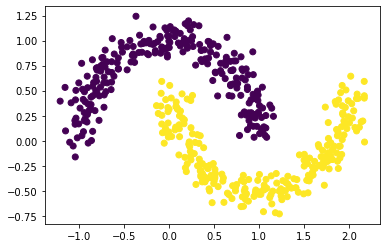

In [3]:
# plot
X, T = data()
plt.scatter(X[:,0],X[:,1],c=T[:,1])
plt.show()

Usually you'd want to normalize the inputs of a neural net, however for in this case it doesn't matter much as the inputs are already similarly scaled. For this reason, no normalization is applied on the data.

First, predictions are made with a **logistic regression** to provide insight on how this model performs in comparison to a Neural Net. A logistic regression with effectively no regularization is used. As shown below, it results in an accuracy of 0.87.

Accuracy: 0.87


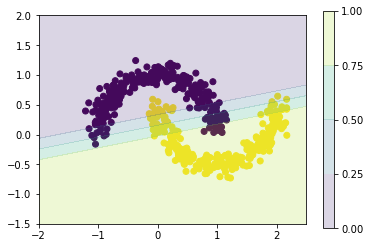

In [4]:
# Make prediction mesh
x1_mesh, x2_mesh = np.meshgrid(np.linspace(-2, 2.5, 100), 
                               np.linspace(-1.5, 2, 100))
X_mesh = np.array([x1_mesh, x2_mesh]).reshape(2, -1).T

# Predict (set C (inverse of alpha) very high to effectively have no regularization)
clf = sklearn.linear_model.LogisticRegression(C=1e8).fit(X,T[:,1])
Y_mesh = clf.predict_proba(X_mesh)

# accuracy
y = clf.predict(X)
acc = accuracy_score(T[:,1],y)
print(f'Accuracy: {acc:.2f}')

# Plot
plt.scatter(X[:, 0], X[:, 1], c=T[:,1]) 
plt.contourf(x1_mesh, x2_mesh, Y_mesh[:,1].reshape(100, 100), # the mesh
             np.linspace(0, 1, 5), alpha=0.2) # the bar at the right  
plt.colorbar()
plt.xlim(-2, 2.5)
plt.ylim(-1.5, 2)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Neural Network Model

Next, a neural network model is implemented from scratch. 

The implemented model has:

* 500 observations ($N=500$), which are the rows of $\mathbf{X}$ $(N \times D)$ and $\mathbf{T}$ $(N \times K)$
* Two inputs ($D=2$), which are the columns of $\mathbf{X}$ respectively
* One hidden layer ($M$ nodes), with a tanh activation function
* Two outputs ($K=2$): which are the columns of $\mathbf{T}$ respectively
* The final layer will have a softmax activation function

Vecotrized notation is used, which leverages the [broadcasting](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) concept of numpy:

$$\mathbf{Y} = softmax((tanh(\mathbf{XW^{(1)}+b^{(1)})W^{(2)} + b^{(2)}})$$

Where:

* tanh is applied element-wise to a matrix
* softmax is applied row-wise to a matrix
* $\mathbf{b^{(1)}}$ is vector of length $M$, and $\mathbf{b^{(2)}}$ is similarly defined
* the addition of the bias vectors is applied per row


First a function <span style="color:blue">init_params()</span> is created, that takes the dimension of the layers and return randomly (standard normal) initialized weight matrices and zero-value initialized bias vectores.

In [5]:
def init_params(D,M,K):
    """
    Purpose:
        Returns the weight matrices and bias vectors for both layers:
            Weight matrices are randomly initialized (standard normal distribution)
            Bias vectors are intialized with zeros
    Inputs:
        D   integer, number of feature inputs
        M   integer, number of hidden nodes
        K   integer, number of classes
    Output:
        params   disctionary of initial weights: 
                 W1  (D,M) matrix
                 b1  (M,) vector
                 W2  (M,K) matrix
                 b2  (K,) vector
    """
       
    W1 = np.random.normal(0, 1, (D,M))
    W2 = np.random.normal(0, 1, (M,K))
    b1 = np.zeros((M,))
    b2 = np.zeros((K,))
    
    params = {'W1':W1,
              'b1':b1,
              'W2':W2,
              'b2':b2}
    
    return params

In [6]:
#Initialize the parameters
params = init_params(2,3,2)
pp.pprint(params)

{'W1': array([[ 0.49671415, -0.1382643 ,  0.64768854],
       [ 1.52302986, -0.23415337, -0.23413696]]),
 'W2': array([[ 1.57921282,  0.76743473],
       [-0.46947439,  0.54256004],
       [-0.46341769, -0.46572975]]),
 'b1': array([0., 0., 0.]),
 'b2': array([0., 0.])}


Next, the function <span style="color:blue">predict()</span> is created, that takes input X and parameters dictionary *params* and returns the predicted probabilities of T, and a dictionary of all interim values that are used to calculate the predicted probabilities.

In [7]:
def predict(X,params):
    """
    Purpose:
        Makes a prediction with the neural network
    Inputs:
        X        (N,D) matrix, features data
        params   dictionary of parameters: {'W1','b1','W2','b2'}
    Output: 
        Y        (N,D) matrix, predicted probabilities
        interim  dictionary of intermediate values:{'A1','Z1','A2','Z2'}
    """
    # unpack dictionary
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']
       
    Z1 = X @ W1 + b1
    A1 = np.tanh(Z1)
    Z2 = A1 @ W2 + b2
    A2 = softmax(Z2)
    Y = A2   
    
    interim = {'A1':A1,
               'Z1':Z1,
               'A2':A2,
               'Z2':Z2}
    
    return Y, interim

In [8]:
Y, interim = predict(X,params)

Next, the function <span style="color:blue">gradient()</span> is created. It takes input X, output T, *params*, and *interim* and return the gradients of of the cross entropy loss (defined below) with respect to the parameters. This function is used to calculate the gradients in order to update the weights of the NN.

$$CELoss = \frac{1}{N} \sum_{n=1}^N \sum_{k=1}^K t_{n,k} \log y_{n,k}$$

In [9]:
def gradient(params, interim, X, T):
    """
    Purpose:
        Get gradients for params
    Inputs:
        params   dictionary of parameters: {'W1','b1','W2','b2'}
        interim  dictionary of intermediate values:{'A1','Z1','A2','Z2'}
        X        (N,D) matrix, features data
        T        (N,K) matrix, target data
    Outputs:
        grads    dictionary of gradients
    """
    N = X.shape[0]
    
    # unpack dictionary
    W1 = params['W1']
    W2 = params['W2']
    b1 = params['b1']
    b2 = params['b2']
    
    A1 = interim['A1']
    A2 = interim['A2']
    Z1 = interim['Z1']
    Z2 = interim['Z2']
    
    dW2 = A1.T @ ((A2-T) * 1/N)
    db2 = np.ones((1, N)) @ ((A2-T) * 1/N)
    dW1 = X.T @ (((A2-T) * 1/N) @ W2.T * (1-A1**2))
    db1 = np.ones((1, N)) @ ((A2-T) * 1/N @ W2.T * (1-A1**2))
    
    # store into dictionary
    grads = {'W1':dW1,
             'b1':db1,
             'W2':dW2,
             'b2':db2,
            }
    
    return grads

In [10]:
grads = gradient(params, interim, X, T)

The function <span style="color:blue">update()</span> is created. It incorporates a learning rate and weight decay. This is the function that will be used to update the parameters in the NN. 

More information on weight decay can be found in Bishop Section 3.1.4 and the beginning of Section 5.5.

In [11]:
def update(params,grads, eta, wd):
    """
    Purpose:
        Update all parameters based on SGD with l2 regularization/weight decay
    Inputs:
        params    dictionary of parameters
        grads     dictionary of gradients
        eta       double, learning rate
        wd        double, weight decay/regularization parameter
    Outputs:
        params    dictionary of updated parameters
    """
    
    for k in params.keys():
        params[k] = params[k] - eta*(grads[k] + wd*params[k])

    return params

In [12]:
eta = 0.05
wd = 0.07
upd = update(params,grads, eta, wd)
pp.pprint(upd)

{'W1': array([[ 0.4861068 , -0.12176704,  0.64540645],
       [ 1.52069133, -0.23941333, -0.23330648]]),
 'W2': array([[ 1.57432969,  0.76410459],
       [-0.46699483,  0.53982469],
       [-0.4710884 , -0.45480703]]),
 'b1': array([[-4.51467179e-03,  5.36690448e-03, -3.75847480e-06]]),
 'b2': array([[-0.00550632,  0.00550632]])}


All the function created above are used to create function <span style="color:blue">model()</span>, which puts it all together and lets the user train a multiclass classification problem with a one hidden layer neural network with $M$ nodes for a certain number of epochs, with a particular learning rate, and weight decay.

In [13]:
def model(X,T,M,epochs,eta,wd,verbose=True):
    """
    Purpose:
        Estimates a neural network model with one hidden layer
    Inputs:
        X      (N,D) matrix, input values
        T      (N,K) matrix, target data
        M      integer, number of hidden nodes
        epochs integer, number of epochs
        eta    double, learning rate
        wd     double, weight decay/regularization parameter
    Outputs:
        params  dictionary of parameters
    """

    # get dims
    N = X.shape[0]
    D = X.shape[1]
    K = T.shape[1]

    # init params
    params = init_params(D,M,K)
    
    # for loop over epochs
    for i in range(epochs):

        # predict
        Y, interim = predict(X, params)
        
        # loss
        loss = log_loss(T, Y)

        # gradient
        grads = gradient(params, interim, X, T)
        
        # update
        params = update(params,grads, eta, wd)
    
        # print
        if verbose and i % 1000 == 0:
            print(f'epoch {i} -- loss: {loss:.2f}')
            
    return params

The model is used to train a neural network on a different scenario, with a noisier dataset and more nodes in the hidden layer. Furthermore, two neural networks are trained: one without weight decay and one with weight decay of $0.005$. This is done to provide some insights on the effect of the weight decay value.

For both models, the model is trained and the predictions for the test set are made. The loss and accuracy of the test set predicitions are calculated and a visualization of the performance of the two models is provided.

From the results obtained it can be seen that the accuracy is better for the high weight decay scenario, while the loss is better for the  training case scenario. The reason for this is that the weight decay determines the penalty that is added to the error function for the weights. A higher weight decay results in a higher penalty, thereby discouraging large weights. This method is used to prevent overfitting of the model. The output shows that the accuracy of the test set is higher in the higher weight decay scenario (0.84 opposed to 0.82), indicating that when weight decay is set to zero, the model overfits on the training data resulting in a lower accuracy on the test data.

When looking at the difference in loss for the training case scenario, for different weight decay hights, the loss will be higher when weight decay is higher. This is because an increased weight decay prevents overfitting on the training set, thereby increasing the log loss of the training case scenario. 

To summarize, the difference can be explained by weight decay preventing overfitting. Which increases the accuracy of the test set, but also results in a higher loss on the training set.

As the aim is to create a model that makes accuracte predictions, a model with weight decay is (in this scenario) preferred over the one without weight decay.


Weight decay = 0.0
epoch 0 -- loss: 1.75
epoch 1000 -- loss: 0.35
epoch 2000 -- loss: 0.34
epoch 3000 -- loss: 0.34
epoch 4000 -- loss: 0.34
Loss on test set: 0.373783178023137

Weight decay = 0.005
epoch 0 -- loss: 1.86
epoch 1000 -- loss: 0.35
epoch 2000 -- loss: 0.35
epoch 3000 -- loss: 0.36
epoch 4000 -- loss: 0.36
Loss on test set: 0.36281979746885373


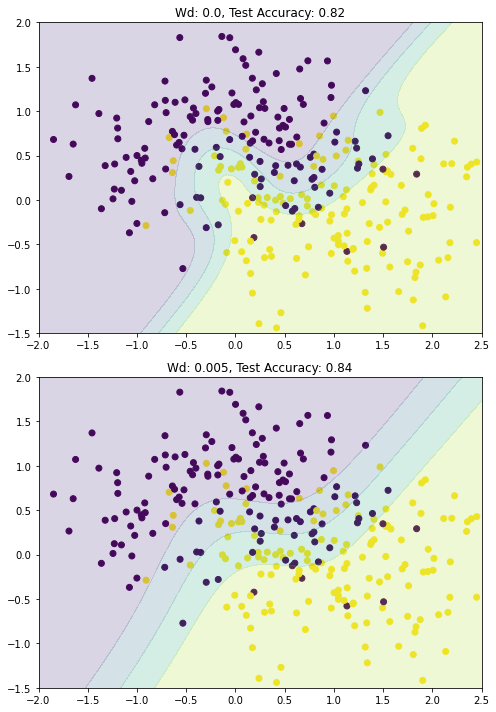

In [14]:
# create train and test set with more noise
X_train,T_train = data(N=300,noise=0.45,random_state=42)
X_test,T_test = data(N=1000,noise=0.45,random_state=43)

#Set the weight decay values
weight_decays = [0.0,0.005]
fig = plt.figure(figsize=(7,10))
i = 0

#For the two weight decay options, the model is trained and the predictions for the test set are made
#The loss on the test set and the accuracy are calculated
#A visualization of the performance of the two models is provided
for weight_decay in weight_decays:  
    i+=1
    print(f'\nWeight decay = {weight_decay}')
    
    #train the model
    params = model(X_train,T_train,
                   M=40,
                   epochs=5000,
                   eta=0.05,
                   wd=weight_decay,
                   verbose=True,
                  )

    # Make prediction mesh
    x1_mesh, x2_mesh = np.meshgrid(np.linspace(-2, 2.5, 100), 
                                   np.linspace(-1.5, 2, 100))
    X_mesh = np.array([x1_mesh, x2_mesh]).reshape(2, -1).T

    # Predict
    Y_mesh,_ = predict(X_mesh,params)

    # accuracy
    Y_test,_ = predict(X_test,params)
    print('Loss on test set:', log_loss(T_test[:,1],Y_test[:,1]))
    acc = accuracy_score(T_test[:,1],Y_test[:,1]>0.5)

    # Plot
    ax = fig.add_subplot(2,1,i)
    ax.set_title(f'Wd: {weight_decay}, Test Accuracy: {acc:.2f}')
    ax.scatter(X_train[:, 0], X_train[:, 1], c=T_train[:,1]) 
    ax.contourf(x1_mesh, x2_mesh, Y_mesh[:,1].reshape(100, 100), # the mesh
                 np.linspace(0, 1, 5), alpha=0.2) # the bar at the right
                 
    ax.set_xlim(-2,2.5)
    ax.set_ylim(-1.5, 2)
    
fig.tight_layout()

